In [2]:
import pickle
# 导入向量化后的数据集
np_vectorized_tfidf = pickle.load(open('model/vectorized_generated_corpus_tfidf.pkl', 'rb'))

In [3]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [11]:
# 利用 RandomizedSearchCV 搜索不同的 维度 和 gamma 值来找到最优解（利用 V-measure 评估）

# Import required libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import v_measure_score
from scipy.stats import uniform

# Define the parameter values that want to search
param_grid = {
    'kpca__n_components': range(2, 11),
    'kpca__gamma': uniform(0, 10),
    'kmeans__n_clusters': range(6, 7)
}

# Define a scoring function that takes in y_true and y_pred as arguments and returns the v_measure_score
def v_measure_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return v_measure_score(y_true, y_pred)

# Create a randomize search object
kpca = KernelPCA()
kmeans = KMeans()
model = Pipeline([('kpca', kpca), ('kmeans', kmeans)])
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, random_state=9, scoring=v_measure_scorer, verbose=3)

# Fit the random search object to the data
random_search.fit(np_vectorized_tfidf, labels)

# Get the best estimator
best_estimator = random_search.best_estimator_
print('best_estimator', best_estimator)

# Use the best estimator to make predictions
y_pred = best_estimator.predict(np_vectorized_tfidf)

# Use V-measure to evaluate the clustering results
score = v_measure_score(labels, y_pred)
print('V-measure:', score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END kmeans__n_clusters=6, kpca__gamma=0.10374153885699955, kpca__n_components=7;, score=0.306 total time=   0.0s
[CV 2/5] END kmeans__n_clusters=6, kpca__gamma=0.10374153885699955, kpca__n_components=7;, score=0.335 total time=   0.0s
[CV 3/5] END kmeans__n_clusters=6, kpca__gamma=0.10374153885699955, kpca__n_components=7;, score=0.779 total time=   0.0s
[CV 4/5] END kmeans__n_clusters=6, kpca__gamma=0.10374153885699955, kpca__n_components=7;, score=0.018 total time=   0.0s
[CV 5/5] END kmeans__n_clusters=6, kpca__gamma=0.10374153885699955, kpca__n_components=7;, score=0.249 total time=   0.0s
[CV 1/5] END kmeans__n_clusters=6, kpca__gamma=4.957732931341461, kpca__n_components=8;, score=0.291 total time=   0.0s
[CV 2/5] END kmeans__n_clusters=6, kpca__gamma=4.957732931341461, kpca__n_components=8;, score=0.630 total time=   0.0s
[CV 3/5] END kmeans__n_clusters=6, kpca__gamma=4.957732931341461, kpca__n_components=8;, 

In [23]:
# 画散点图之前，首先用 KernelPCA 降维
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=1.5)
decomposition_data = kpca.fit_transform(np_vectorized_tfidf)

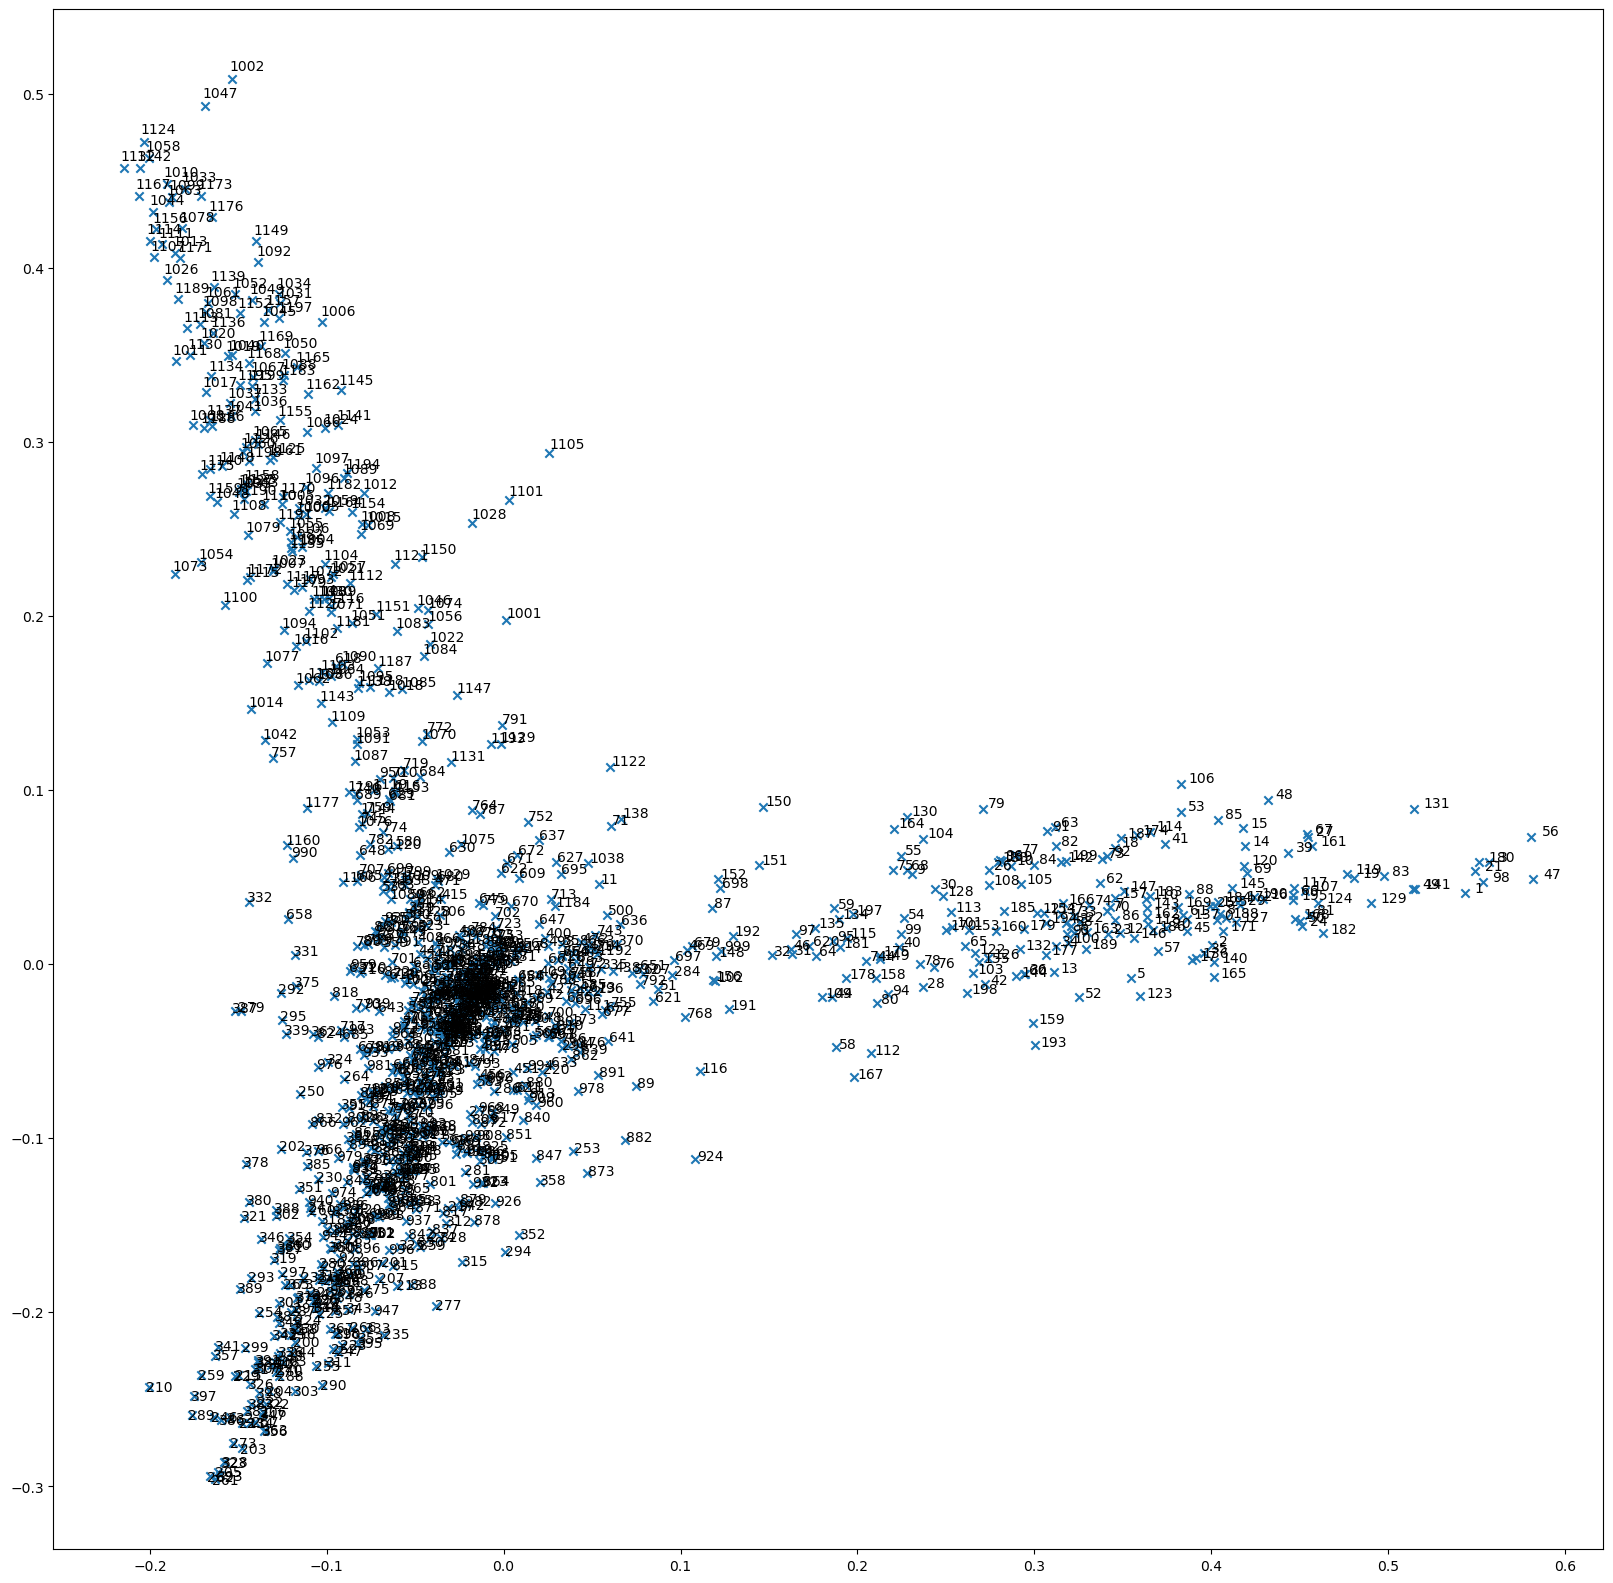

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], marker='x')
for i in range(len(decomposition_data)):
    plt.text(decomposition_data[:, 0][i] * 1.01, decomposition_data[:, 1][i] * 1.01, i, fontsize=10)
plt.show()

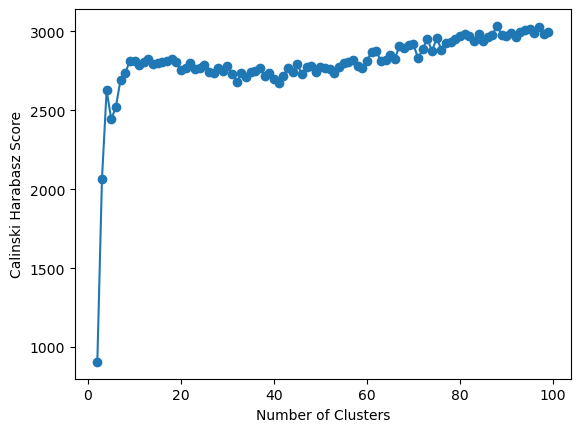

In [25]:
# K-means 算法聚类并利用 Calinski Harabasz Score 评估效果
from sklearn.cluster import KMeans
from sklearn import metrics
calinski_harabasz_score_list = []
for n_cluster in range(2, 100):
    y_pred = KMeans(n_clusters=n_cluster, init='k-means++', random_state=9).fit_predict(decomposition_data)
    current_score = metrics.calinski_harabasz_score(decomposition_data, y_pred)
    calinski_harabasz_score_list.append(current_score)

plt.plot(range(2,100), calinski_harabasz_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [26]:
calinski_harabasz_score_list.index(max(calinski_harabasz_score_list))

86

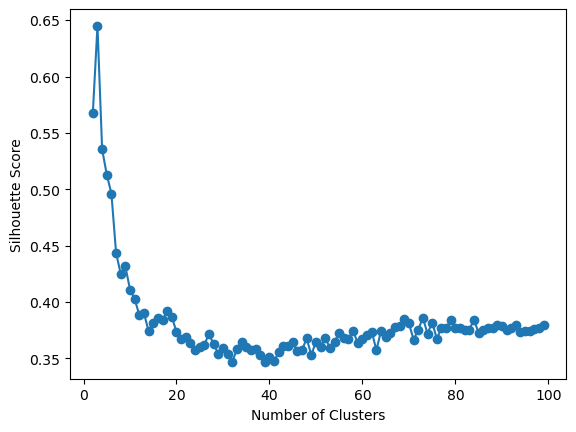

In [27]:
# K-means 算法聚类并利用 Silhouette Score（轮廓系数）评估效果
silhouette_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = metrics.silhouette_score(decomposition_data, km.labels_ , metric='euclidean')
    silhouette_score_list.append(current_score)

plt.plot(range(2,100), silhouette_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [28]:
silhouette_score_list.index(max(silhouette_score_list))

1

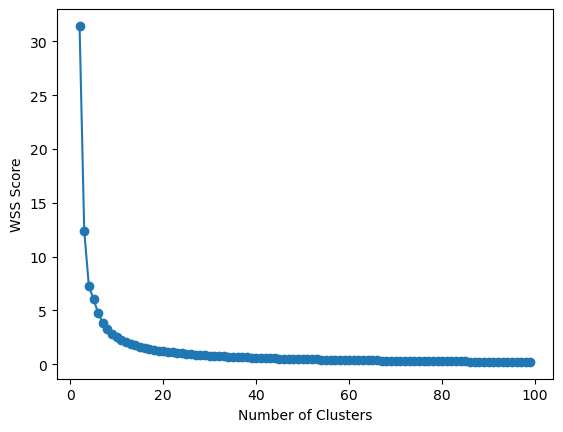

In [29]:
# K-means 算法聚类并利用 WSS（Within-cluster Sum of Squares）评估效果
WSS_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = km.inertia_
    WSS_score_list.append(current_score)

plt.plot(range(2,100), WSS_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS Score')
plt.show()

In [30]:
# 选用 k 值做 K-means 算法聚类
y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data)

In [31]:
print(y_pred[:10])

[2 2 2 2 4 2 5 2 2 5]


In [32]:
import numpy as np
# 用 dict 统计出所有类别的坐标
y_pred_dict = {}
for i in range(len(decomposition_data)):
    if y_pred[i] not in y_pred_dict:
        y_pred_dict[y_pred[i]] = decomposition_data[i].reshape(1, 2)
    else:
        y_pred_dict[y_pred[i]] = np.vstack((y_pred_dict[y_pred[i]], decomposition_data[i]))

In [33]:
for key, value in y_pred_dict.items():
    print(key, value[:, 0].mean())

2 0.4153392219421091
4 -0.08965861781554971
5 0.2415938693152144
0 -0.02171811085051531
3 -0.09318981578275612
1 -0.15625782954704195


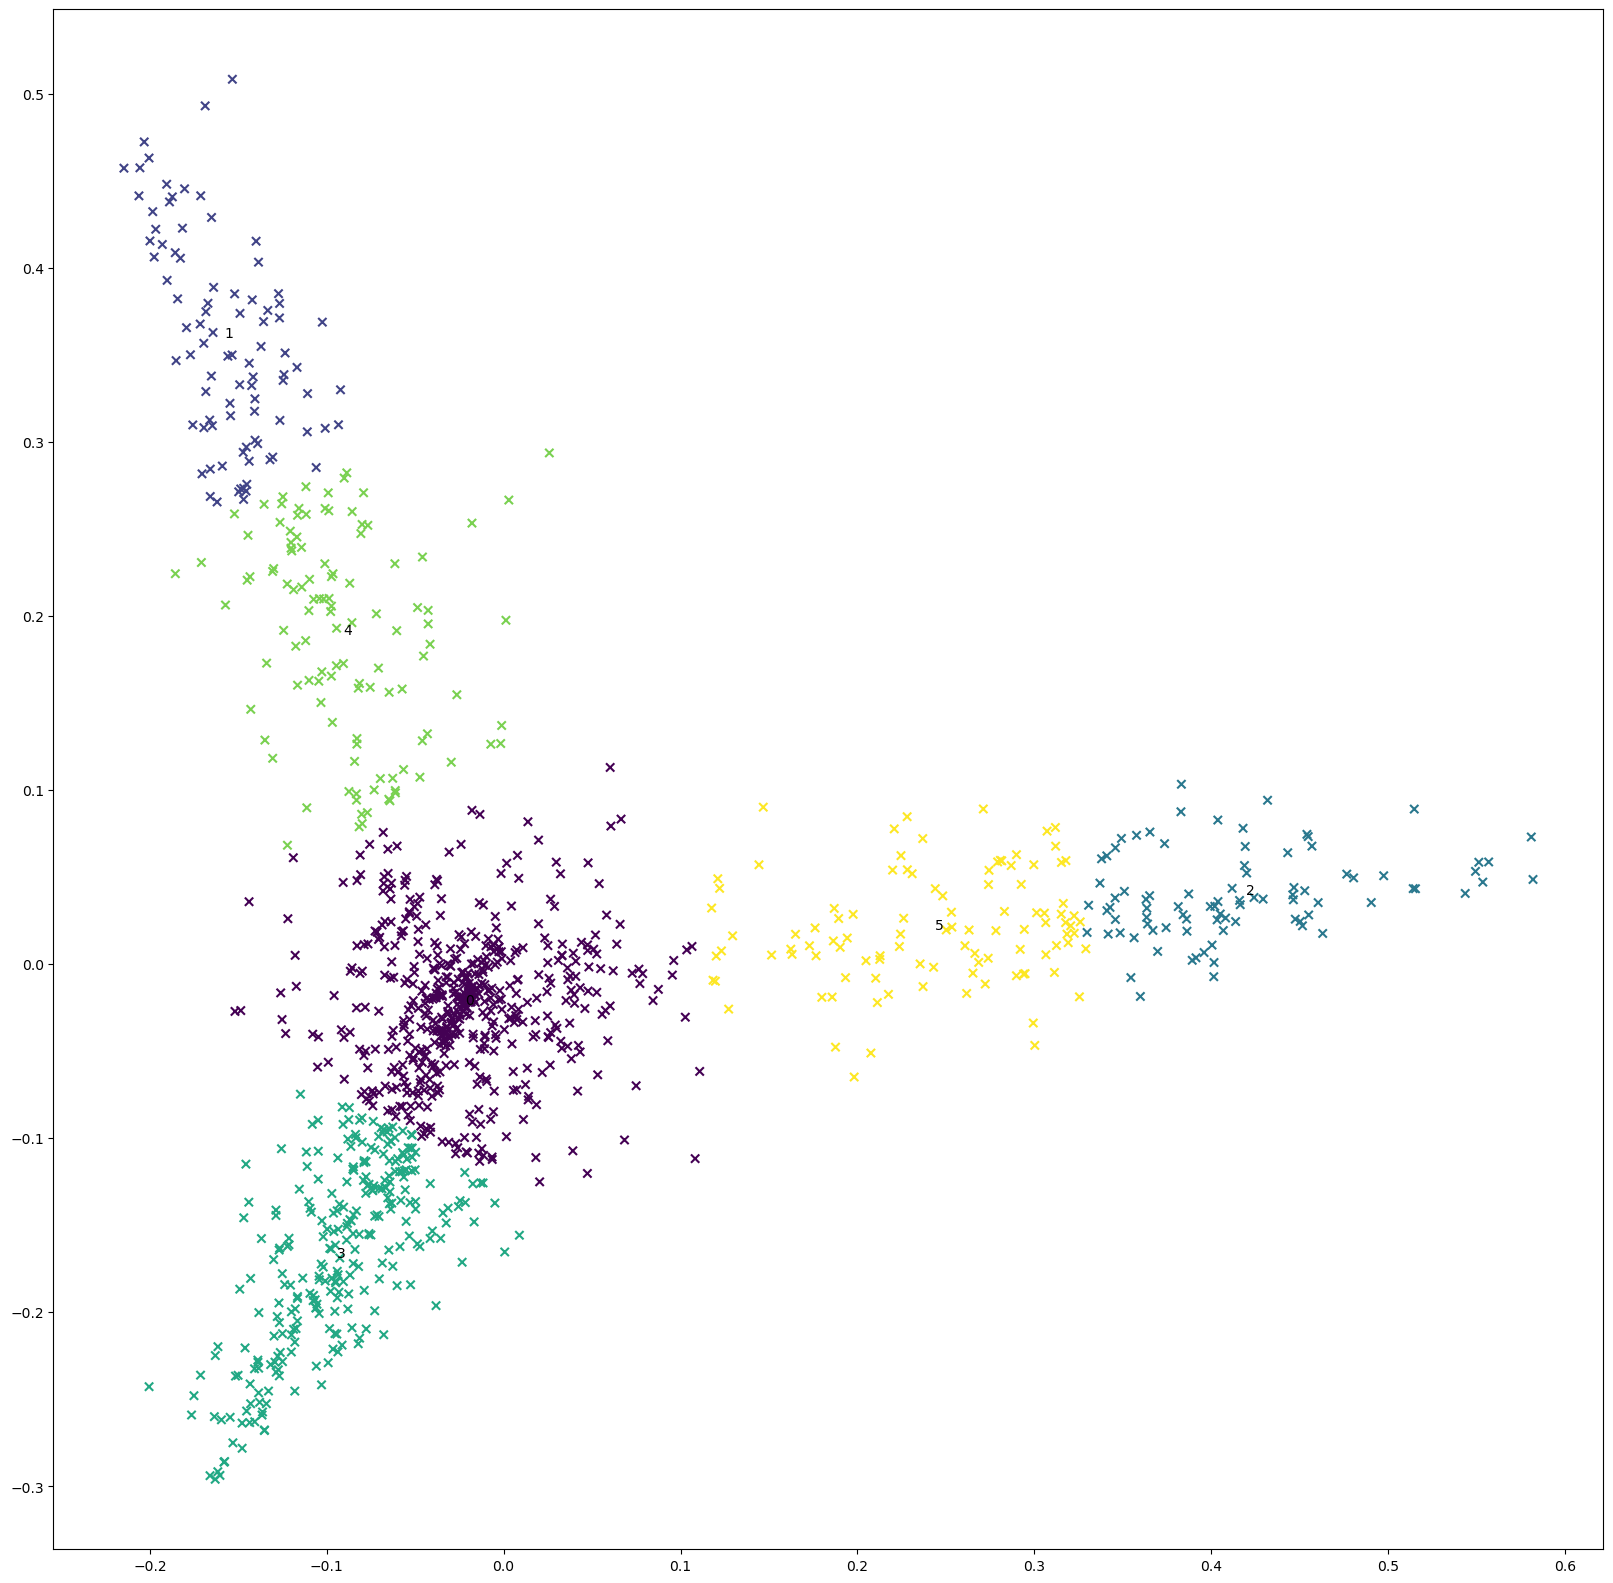

In [34]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], c=y_pred, marker='x')
for key, value in y_pred_dict.items():
    plt.text(value[:, 0].mean() * 1.01, value[:, 1].mean() * 1.01, key, fontsize=10)
plt.show()

In [35]:
# 利用 Calinski Harabasz Score 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.calinski_harabasz_score(decomposition_data, y_pred)

2523.0732557850483

In [36]:
# 利用 Silhouette Score（轮廓系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
km = KMeans(n_clusters=6, random_state=9)
y_pred = km.fit_predict(decomposition_data)
metrics.silhouette_score(decomposition_data, km.labels_, metric='euclidean')

0.49615210375981617

In [37]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [38]:
labels[:10]

['CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP']

In [39]:
# 利用 Homogeneity 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.homogeneity_score(labels, y_pred)

0.5201727046123753

In [40]:
# 利用 Completeness 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.completeness_score(labels, y_pred)

0.6141185157433506

In [41]:
# 利用 V-measure 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.v_measure_score(labels, y_pred)

0.5632551562667902

In [42]:
# 利用 Adjusted Rand Index（调整兰德系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_rand_score(labels, y_pred)

0.3474011625813265

In [43]:
# 利用 Adjusted Mutual Information Score（调整互信息）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_mutual_info_score(labels, y_pred)

0.5604570770108419

In [44]:
# 利用 Fowlkes-Mallows scores 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.fowlkes_mallows_score(labels, y_pred)

0.4977517378698821